# Gale Shapley Matching with Bandits

To decide a matching between $\mathcal{B}$ and $\mathcal{L}$, we introduce the binary decision variable $\mathbf{x}$ := $(x_{bl})_{(b, l)\in \mathcal{B} \times \mathcal{L}}$ such that $x_{bl}$ = 1 if the loan from lender $l$ is assigned and accepted by borrower $b$ and 0 otherwise. It is supposed that when the borrower $b$ and the lender $l$ are matched, the borrower and the lender gain utilities of $u_b(h)$ and $u_l(h)$ respectively. To simplify  our settings, we assume that all utilities $u_b(h)$ and $u_l(h)$ are non-negative, and that for a lender $l$, $u_b(l)$ $\neq$ $u_{b'}(l)$, for $b \neq b'$ and similarly, for a borrower $b$, $u_l(b)$ $\neq$ $u_{l'}(b)$, for $l \neq l'$. The borrower-lender pair $(b, l)$ yields the utility of $u_{bl}:= u_b + u_l $ and the total utility of a matching $\mathbf{x} \in {0, 1}^{|\mathcal{B}| \times |\mathcal{L}|}$ is given by

\begin{equation*}
    \sum_{b \in \mathcal{B}} \sum_{l \in \mathcal{L}} u_{bl} x_{bl}
\end{equation*}
In our work, we consider a \textcolor{red}{many-many matching} where each borrower is matched to many lenders and each lender is also matched to multiple borrowers. For a matching $\mathbf{x}$, let $m_x(b)\in \mathcal{L}$ be the lender to which the borrower $b$ is assigned, and $M_x(l) \subseteq \mathcal{B}$ be the set of borrowers that are assigned to lender $l$, that is,
\begin{align*}
    m_x(b) = l \Longleftrightarrow x_{bl} = 1 \\
    M_x(l) := \{l \in \mathcal{L} \ | \ x_{bl} = 1\}
\end{align*}
\\

\noindent \textbf{Definition 1} Let $\mathbf{x} \in \{0, 1\}^{|\mathcal{B}| \times |\mathcal{L}|}$ be a matching. A pair $(b, l) \in \mathcal{B} \times \mathcal{L}$ is a blocking pair for $\mathbf{x}$ if the following conditions are satisfied:

\begin{enumerate}
    \item $x_{bl}=0$
    \item $x(b)$ is null or $u_b(l)$ $>$ $u_{b}(m_x(b))$
    \item $|M_x(b)|$ $< q_b$ or $\exists$ $l' \in M_x(b)$ and such that $u_b(l) > u_b(l')$.
\end{enumerate} 
\vspace*{.1in}

Since the individual rationality condition is fulfilled from Assumption 1 for all $(b, l) \in \mathcal{B} \times \mathcal{L}$, a stable matching is defined based on the absence of blocking pairs as follows: a matching $\mathbf{x}$ is stable if it does not have any blocking pairs. \\

\noindent \textbf{Definition 2.} A matching $\mathbf{x}$ is stable if it does not have blocking pairs. The stable matching problem can be characterized by the following linear inequalities as mentioned in \cite{baiou2000stable} and is formalized using the following inequality:

\begin{equation} \label{eq:eq1}
    q_b x_{bl} + q_b\sum_{l' \succ_b l }x_{bl'} + \sum_{b' \succ_{l} b} x_{b'l} \geq q_l
\end{equation}
The proof of the statement can be found in the same paper \cite{baiou2000stable}. We use this notation to arrive at a linear program that maximizes the utility of the matching while minimizing the number of blocking pairs. Defining a binary decision variable $\mathbf{w}$ := $(w_{b, l})$ $\in \{0, 1\}^{|\mathcal{B}| \times |\mathcal{L}|}$, we use the following constraint: 

\begin{equation}
        q_b x_{bl} + q_b\sum_{l' \succ_b l }x_{bl'} + \sum_{b' \succ_{l} b} x_{b'l} \geq q_l (1- w_{bl})
\end{equation}

In [155]:
import pandas as pd
import numpy as np
from gurobipy import *
import random
from collections import defaultdict 
import math

In [198]:
def model_gs_matching(n_b, n_l, u_b, u_l, c, q, obj_util, lambda_1, lambda_2, LogToConsole=True, TimeLimit=60):
    model = Model()
    model.params.LogToConsole = LogToConsole
    model.params.TimeLimit = TimeLimit # seconds
    x = {}
    w = {}
    for b_idx in range(1, n_b+1):
        x[b_idx] = {}
        w[b_idx] = {}
        for l_idx in range(1, n_l+1): 
            x_name = "x_{}_{}".format(b_idx, l_idx)
            x[b_idx][l_idx] = model.addVar(lb=0.0, ub=1.0, vtype=GRB.BINARY, name=x_name)
            w_name = "w_{}_{}".format(b_idx, l_idx)
            w[b_idx][l_idx] = model.addVar(lb=0.0, ub=1.0, vtype=GRB.BINARY, name=w_name)

    for l_idx in range(1, n_l+1):
        model.addConstr(quicksum(x[b_idx][l_idx] for b_idx in range(1, n_b+1)) <= 1)
    
    for b_idx in range(1, n_b+1):
        model.addConstr(quicksum((q[l_idx]*x[b_idx][l_idx]) for l_idx in range(1, n_l+1)) >= c[b_idx])
    
    for b_ix in range(1, n_b+1):
        for l_idx in range(1, n_l+1):
            constr_obj_1 = c[b_idx]*x[b_idx][l_idx]
            constr_obj_2 = 0
            constr_obj_3 = 0
            
            for b_idx_2 in range(1, n_b+1):
                if b_idx != b_idx_2:
#                     print(b_idx, b_idx_2)
                    if u_l[l_idx][b_idx] < u_l[l_idx][b_idx_2]:
                        constr_obj_2 += (x[b_idx][l_idx])
            constr_obj_2 *= c[b_idx] 

            for l_idx_2 in range(1, n_l+1):
                if l_idx != l_idx_2:
                    if u_b[b_idx][l_idx] < u_b[b_idx][l_idx_2]:
                        constr_obj_3 += (q[l_idx] * x[b_idx][l_idx])
                        
            model.addConstr((constr_obj_1 + constr_obj_2 + constr_obj_3) >= (c[b_idx]* (1-w[b_idx][l_idx])))
    
    model.setObjective(lambda_1*quicksum(obj_util[b_idx][l_idx]*x[b_idx][l_idx] for l_idx in range(1, n_l+1) for b_idx in range(1, n_b+1)) - \
                       lambda_2*quicksum(w[b_idx][l_idx] for l_idx in range(1, n_l+1) for b_idx in range(1, n_b+1)) , GRB.MAXIMIZE)
    model.optimize()
    if model.status != 2:
        print("Optimal Solution not found !!!")
        return -1, -1
    
    borrower_matches = {}
    lender_matches = {}
    for b_idx in range(1, n_b+1):
        borrower_matches[b_idx] = []
#         print("Borrower {} matched to lenders: ".format(b_idx))
        for l_idx in range(1, n_l+1):
            if x[b_idx][l_idx].X == 1:
#                 print(l_idx)
                borrower_matches[b_idx].append(l_idx)
                if l_idx not in lender_matches:
                    lender_matches[l_idx] = -1
                lender_matches[l_idx] = b_idx
    
    return borrower_matches, lender_matches, model.objVal

In [199]:
def lender_utility(l, b, sim_values, amount_lenders, borrower_rates):
    return sim_values[b][l] #+ borrower_rates[b]*amount_lenders[l]

# Risk preference not considered for now
def borrower_utility(l, b, sim_values, risk_preference):
    return (sim_values[b][l] + risk_preference[b][l])/2.0 # 2.0 is for normalization

In [200]:

VARIANCE = 0.05
NUM_SIMS_PER_STEP=50
def rewards(mean, variance):
    return np.random.normal(mean, variance, 1)[0]

def average_reward(base_reward, rewards_list):
    return base_reward + (rewards(1, VARIANCE) + np.sum(rewards_list))/(len(rewards_list)+1) 

def reward_ucb(base_reward, rewards_list, time):
    avg_reward = average_reward(base_reward, rewards_list)
    
    if len(rewards_list) > 1:
        return avg_reward + np.sqrt(2*np.log(time)/(len(rewards_list)-1))
    else:
        return avg_reward
    

def gs_bandit_method_baseline(n_b, n_l, u_b, u_l, c, q, lambda_1, lambda_2, preference_borrowers, preference_lenders):
    u = defaultdict(lambda: defaultdict(float))
    obj = defaultdict(lambda: defaultdict(float))
    for l_idx in range(1, n_l+1):
        for b_idx in range(1, n_b+1):
            # we optimize for lender_borrower returns
            u[l_idx][b_idx] = u_b[b_idx][l_idx] + u_l[l_idx][b_idx] # lender utility + borrower utility
            obj[b_idx][l_idx] = u[l_idx][b_idx] # objective fn utility same as lender-borrower utility

    borrower_matches_optimal, lender_matches_optimal, objVal = model_gs_matching(n_b, n_l, u_b, u, c, q, obj, lambda_1, lambda_2, LogToConsole=False)
  
    return lender_matches_optimal, objVal
            
    
    
def gs_bandit_method_basic(n_b, n_l, u_b, u_l, c, q, lambda_1, lambda_2, preference_borrowers, preference_lenders):
    T = 10 # horizon, n
    
    curr_util_l = defaultdict(lambda: defaultdict(list))
    rewards_list_l = defaultdict(lambda: defaultdict(list))
    util_send_l = defaultdict(lambda: defaultdict(float))
    
    # For each lender l, initialize the current utility for a borrower b as u_l(b) + N(1, 0.25)
    # and then initilize the util_send list for matching with the current utility
    for l_idx in range(1, n_l+1):
        for b_idx in range(1, n_b+1):
            curr_util_l[l_idx][b_idx] = average_reward(u_l[l_idx][b_idx], rewards_list_l[l_idx][b_idx])
            util_send_l[l_idx][b_idx] = curr_util_l[l_idx][b_idx]
    
    # Baseline GS
    lender_matches_optimal = []
    while ( len(lender_matches_optimal) < n_l):
        lender_matches_optimal, objVal_optimal = gs_bandit_method_baseline(n_b, n_l, u_b, u_l, c, q, lambda_1, lambda_2, preference_borrowers, preference_lenders)
    
    
    regret_lender_t = defaultdict(lambda: defaultdict(list))
    
    for s_idx in range(NUM_SIMS_PER_STEP):
        print("Simulation no.: " + str(s_idx))
        for t in range(1, T+1):
            print("Matching time step " + str(t))
    #         u = {}
    #         for b_idx in range(1, n_b+1):
    #             u[b_idx] = {}
    #             for l_idx in range(1, n_l+1):
    #                 u[b_idx][l_idx] = u_l[l_idx][b_idx] #lender optimal
            borrower_matches, lender_matches, objVal = model_gs_matching(n_b, n_l, u_b, util_send_l, c, q, util_send_l, lambda_1, lambda_2, LogToConsole=False)
#             if borrower_matches == -1 or lender_matches == -1:
#                 print("Non-optimal lending")
#                 for l_idx in range(1, n_l+1):
#                     regret_lender_t[l_idx].append(-1)
#                 continue

            for l_idx in range(1, n_l+1):
                if l_idx in lender_matches:
                    b_match = lender_matches[l_idx] # matched borrower
                    rewards_list_l[l_idx][b_match].append(rewards(u_b[b_match][l_idx], VARIANCE)) # update the reward list for l-b pair
                    # For each lender l, the current utility for a borrower b becomes u_l(b) + [N(1, 0.25) + \sum (rewards_list)]/(1 + len(rewards_list))
                    # util_send becomes curr_util[l][b] + sqrt(2*log t/T_{b,l}(t-1))
                    curr_util_l[l_idx][b_match] = average_reward(u_l[l_idx][b_match], rewards_list_l[l_idx][b_match])
                    util_send_l[l_idx][b_match] = reward_ucb(u_l[l_idx][b_match], rewards_list_l[l_idx][b_match], t)

                    # print(lender_matches_optimal[l_idx], b_match)
                    r = u_l[l_idx][lender_matches_optimal[l_idx]] + u_b[lender_matches_optimal[l_idx]][l_idx] - u_l[l_idx][b_match]
                else:
#                     if len(regret_lender_t[l_idx][s_idx]) > 0:
#                         r = regret_lender_t[l_idx][s_idx][-1] # same as before
#                     else:
                    r = u_l[l_idx][lender_matches_optimal[l_idx]] + u_b[lender_matches_optimal[l_idx]][l_idx]
              
                regret_lender_t[l_idx][t].append(r)
            
                print("Lender {} with regret {}".format(l_idx, r))
    
    return regret_lender_t
    

In [201]:
def gs_bandit_method(n_b, n_l, preference_borrowers, preference_lenders):
    T = 100 # horizon, n
    
    for t in range(T):
        l_unmatched = n_l
        
        while len(l_unmatched) > 0:
            borrower_matches, lender_matches = model_gs_matching(n_b, n_l, u_b, u_l, c, q, lambda_1, lambda_2, LogToConsole=False)

            if borrower_matches == -1:
                print("Matching has reached an unstable configuration. Aborting!!!")
                break

            for l_idx in lender_matches:
                b_matched_l = lender_matches[l_idx][0] # every lender has 1 borrower
                b_most_preferred_l = preference_borrowers[b_idx][0]

#                 if b_matched_l == b_most_preferred_l:
                    

            
        
    return ""

In [202]:
def simulate_lending():
    u_b = {}
    u_l = {}
    
    n_b, n_l = 20, 60

    preference_borrowers = []
    preference_lenders = []
    
    sim_values = {}
    for b_idx in range(1, n_b+1):
        sim_values[b_idx] = {}
        for l_idx in range(1, n_l+1):
            sim_values[b_idx][l_idx]  = random.uniform(0, 1)
    
    borrower_rates = {}
    for b_idx in range(1, n_b+1):
        borrower_rates[b_idx]  = random.uniform(0, 1)

    # This part is not used for now - risk_preference
    risk_preference = {}
    categories = list(range(1, 6))
    lender_risk_categories = {}
    for l_idx in range(1, l_idx+1):
        lender_risk_categories[l_idx] = {}
        for c_idx in categories:
            lender_risk_categories[l_idx][c_idx] = random.uniform(0, 1)
    borrower_categories = {}
    for b_idx in range(1, n_b+1):
        borrower_categories[b_idx] = random.sample(categories, 1)[0] # consider every borrower has 1 category for now
        risk_preference[b_idx] = {}
        for l_idx in range(1, n_l+1):
            risk_preference[b_idx][l_idx] = lender_risk_categories[l_idx][borrower_categories[b_idx]]
    
    # c - borrower amount, q - lender amount
    c = {}
    q = {}

    while True:
        sum_c = 0
        sum_q = 0
        for b_idx in range(1, n_b+1):
            c[b_idx] = random.sample(range(5, 40), 1)[0]
            sum_c += c[b_idx]

        for l_idx in range(1, n_l+1):
            q[l_idx] = random.sample(range(1, 10), 1)[0]
            sum_q += q[l_idx]

        if sum_q > sum_c:
            break

    # utilities
    for b_idx in range(1, n_b+1):
        u_b[b_idx] = {}
        for l_idx in range(1, n_l+1):
            u_b[b_idx][l_idx] = borrower_utility(l_idx, b_idx, sim_values, risk_preference)
        preference_borrowers = sorted(range(1, len(u_b[b_idx])+1), key=lambda k: u_b[b_idx][k])

    for l_idx in range(1, n_l+1):
        u_l[l_idx] = {}
        for b_idx in range(1, n_b+1):
            u_l[l_idx][b_idx] = lender_utility(l_idx, b_idx, sim_values, q, borrower_rates)
        preference_lenders = sorted(range(1, len(u_l[l_idx])+1), key=lambda k: u_l[l_idx][k])
    
    lambda_1 = 0.5
    lambda_2 = 1-lambda_1

    print("Configuration:")
    print("Borrower preferences: ", u_b)
    print("Borrower requests: ", c)
    print("Lender prefernces: ", u_l)
    print("Lender budgets: ", q)
    
    return gs_bandit_method_basic(n_b, n_l, u_b, u_l, c, q, lambda_1, lambda_2, preference_borrowers, preference_lenders)
#     model_gs_matching(n_b, n_l, u_b, u_l, c, q, lambda_1, lambda_2, LogToConsole=False)

In [203]:
import matplotlib.pyplot as plt

def plot_lines(regret):
    for l_idx in regret:
        time_points = []
        time_points_ub = []
        time_points_lb = []
        for t_idx in regret[l_idx]:
            time_points.append(np.mean(regret[l_idx][t_idx]))
            time_points_ub.append(np.mean(regret[l_idx][t_idx]) + np.std(regret[l_idx][t_idx]))
            time_points_lb.append(np.mean(regret[l_idx][t_idx]) - np.std(regret[l_idx][t_idx]))
            
        x = range(len(time_points))
        plt.plot(x, time_points, 'k-')
        plt.fill_between(x, time_points_lb, time_points_ub)
        plt.show()
    

In [ ]:

regret_lender = simulate_lending()



Configuration:
Borrower preferences:  {1: {1: 0.2670183143578068, 2: 0.61710468575555, 3: 0.683661877411107, 4: 0.4781720792537535, 5: 0.45355308367385344, 6: 0.4902922854407141, 7: 0.606777800389992, 8: 0.50486628099408, 9: 0.307200878023227, 10: 0.6488362678696644, 11: 0.7148426632568616, 12: 0.10311830293783131, 13: 0.07363456235744936, 14: 0.4301090340924017, 15: 0.41961779730960885, 16: 0.28189009246866176, 17: 0.5047828152707512, 18: 0.7379602465412374, 19: 0.6848817184616226, 20: 0.4203367837187516, 21: 0.4628628785630116, 22: 0.45077725824631887, 23: 0.47185855474332383, 24: 0.1675067731431969, 25: 0.2397016801933325, 26: 0.3487650291940165, 27: 0.7620706990405215, 28: 0.6585709115670151, 29: 0.6403984700053381, 30: 0.42295180569250707, 31: 0.30400167223607205, 32: 0.6301545448510527, 33: 0.4851347411806462, 34: 0.4864518659444039, 35: 0.1693205826018656, 36: 0.8340756916902454, 37: 0.8915532993557331, 38: 0.7189831652756333, 39: 0.44022152240904466, 40: 0.47037564438618157, 41

Simulation no.: 0
Matching time step 1
Lender 1 with regret 1.1449646328796375
Lender 2 with regret 1.4476891462923325
Lender 3 with regret 0.7366625599888637
Lender 4 with regret 0.9174916326779466
Lender 5 with regret 1.6612201970176113
Lender 6 with regret 0.9850108765034189
Lender 7 with regret 0.9036999937602033
Lender 8 with regret 0.9373403432480472
Lender 9 with regret 1.4442056207372804
Lender 10 with regret 1.84082047001703
Lender 11 with regret 1.027707678747699
Lender 12 with regret 1.0530057796504046
Lender 13 with regret 1.5355420564488649
Lender 14 with regret 0.9896162263537477
Lender 15 with regret 1.355590499657723
Lender 16 with regret 1.3550898277065264
Lender 17 with regret 1.002319121392679
Lender 18 with regret 0.6317784851357945
Lender 19 with regret 0.9229126101416881
Lender 20 with regret 1.0779070720763309
Lender 21 with regret 0.6576120740074759
Lender 22 with regret 1.080279054125858
Lender 23 with regret 1.4245646739397524
Lender 24 with regret 1.859456640

Lender 1 with regret 0.7218455405751997
Lender 2 with regret 0.758150739197722
Lender 3 with regret 1.5177062773817105
Lender 4 with regret 0.9174916326779466
Lender 5 with regret 0.8124108084252583
Lender 6 with regret 0.737409547103545
Lender 7 with regret 1.0691431630787211
Lender 8 with regret 0.9373403432480472
Lender 9 with regret 0.974788521025056
Lender 10 with regret 1.84082047001703
Lender 11 with regret 1.027707678747699
Lender 12 with regret 1.0530057796504046
Lender 13 with regret 0.6689355109198513
Lender 14 with regret 0.8471395376485321
Lender 15 with regret 1.355590499657723
Lender 16 with regret 1.3550898277065264
Lender 17 with regret 0.7827302905337795
Lender 18 with regret 0.6317784851357945
Lender 19 with regret 0.9229126101416881
Lender 20 with regret 1.0779070720763309
Lender 21 with regret 1.3446113221441045
Lender 22 with regret 1.26775514648396
Lender 23 with regret 1.7600795569133396
Lender 24 with regret 1.8711884745107998
Lender 25 with regret 0.8673075411

Lender 2 with regret 1.4476891462923325
Lender 3 with regret 0.7366625599888637
Lender 4 with regret 0.9174916326779466
Lender 5 with regret 1.6612201970176113
Lender 6 with regret 0.9850108765034189
Lender 7 with regret 1.0691431630787211
Lender 8 with regret 0.9373403432480472
Lender 9 with regret 1.09430369566822
Lender 10 with regret 0.9039566516012394
Lender 11 with regret 1.027707678747699
Lender 12 with regret 1.0530057796504046
Lender 13 with regret 0.6689355109198513
Lender 14 with regret 0.8471395376485321
Lender 15 with regret 1.355590499657723
Lender 16 with regret 1.3550898277065264
Lender 17 with regret 1.002319121392679
Lender 18 with regret 0.6317784851357945
Lender 19 with regret 0.9229126101416881
Lender 20 with regret 1.0779070720763309
Lender 21 with regret 0.6576120740074759
Lender 22 with regret 1.26775514648396
Lender 23 with regret 1.4245646739397524
Lender 24 with regret 1.0756268570736705
Lender 25 with regret 0.598375431483956
Lender 26 with regret 1.00005889

Lender 1 with regret 1.1449646328796375
Lender 2 with regret 1.4476891462923325
Lender 3 with regret 0.7366625599888637
Lender 4 with regret 0.9174916326779466
Lender 5 with regret 1.6612201970176113
Lender 6 with regret 0.9850108765034189
Lender 7 with regret 1.0691431630787211
Lender 8 with regret 0.9373403432480472
Lender 9 with regret 1.4442056207372804
Lender 10 with regret 1.84082047001703
Lender 11 with regret 0.8123746666400173
Lender 12 with regret 1.5802815502786796
Lender 13 with regret 1.5355420564488649
Lender 14 with regret 1.2043646398608163
Lender 15 with regret 1.3275056220158445
Lender 16 with regret 1.3550898277065264
Lender 17 with regret 1.002319121392679
Lender 18 with regret 1.4466857450364043
Lender 19 with regret 1.3805035592909976
Lender 20 with regret 1.0779070720763309
Lender 21 with regret 1.1238261784140877
Lender 22 with regret 1.0653521477037884
Lender 23 with regret 1.6057271641575899
Lender 24 with regret 1.2474028555180392
Lender 25 with regret 0.5983

Lender 1 with regret 1.1449646328796375
Lender 2 with regret 1.4476891462923325
Lender 3 with regret 0.7366625599888637
Lender 4 with regret 0.9174916326779466
Lender 5 with regret 1.6612201970176113
Lender 6 with regret 0.9850108765034189
Lender 7 with regret 1.0691431630787211
Lender 8 with regret 1.0996675257844544
Lender 9 with regret 1.4442056207372804
Lender 10 with regret 1.84082047001703
Lender 11 with regret 0.8123746666400173
Lender 12 with regret 1.0530057796504046
Lender 13 with regret 0.6766231432086455
Lender 14 with regret 0.9896162263537477
Lender 15 with regret 1.3275056220158445
Lender 16 with regret 1.3550898277065264
Lender 17 with regret 1.002319121392679
Lender 18 with regret 1.4466857450364043
Lender 19 with regret 1.3805035592909976
Lender 20 with regret 0.7918846891633491
Lender 21 with regret 1.1238261784140877
Lender 22 with regret 1.26775514648396
Lender 23 with regret 0.7798513282238965
Lender 24 with regret 1.0384347620210788
Lender 25 with regret 0.867307

Lender 1 with regret 1.1449646328796375
Lender 2 with regret 1.4476891462923325
Lender 3 with regret 0.7366625599888637
Lender 4 with regret 0.9174916326779466
Lender 5 with regret 1.6612201970176113
Lender 6 with regret 0.9850108765034189
Lender 7 with regret 1.0691431630787211
Lender 8 with regret 0.9373403432480472
Lender 9 with regret 1.4442056207372804
Lender 10 with regret 1.84082047001703
Lender 11 with regret 0.8123746666400173
Lender 12 with regret 1.0530057796504046
Lender 13 with regret 0.6766231432086455
Lender 14 with regret 1.2043646398608163
Lender 15 with regret 1.3275056220158445
Lender 16 with regret 1.3550898277065264
Lender 17 with regret 1.002319121392679
Lender 18 with regret 1.4466857450364043
Lender 19 with regret 1.3805035592909976
Lender 20 with regret 0.7918846891633491
Lender 21 with regret 0.9230504629554499
Lender 22 with regret 0.9282321749220835
Lender 23 with regret 1.5004109174468259
Lender 24 with regret 1.642846976418809
Lender 25 with regret 0.86730

Lender 1 with regret 1.1449646328796375
Lender 2 with regret 0.8084886160166559
Lender 3 with regret 0.7366625599888637
Lender 4 with regret 1.2779860436642783
Lender 5 with regret 1.6612201970176113
Lender 6 with regret 0.9850108765034189
Lender 7 with regret 0.9036999937602033
Lender 8 with regret 0.9373403432480472
Lender 9 with regret 1.4442056207372804
Lender 10 with regret 1.84082047001703
Lender 11 with regret 0.8123746666400173
Lender 12 with regret 1.0530057796504046
Lender 13 with regret 0.889859057950422
Lender 14 with regret 1.2043646398608163
Lender 15 with regret 1.3275056220158445
Lender 16 with regret 1.3550898277065264
Lender 17 with regret 1.002319121392679
Lender 18 with regret 1.4466857450364043
Lender 19 with regret 1.3548256530895513
Lender 20 with regret 0.7918846891633491
Lender 21 with regret 1.3446113221441045
Lender 22 with regret 0.9282321749220835
Lender 23 with regret 1.4245646739397524
Lender 24 with regret 1.0384347620210788
Lender 25 with regret 0.86730

Lender 1 with regret 1.1449646328796375
Lender 2 with regret 1.4476891462923325
Lender 3 with regret 0.7366625599888637
Lender 4 with regret 1.2779860436642783
Lender 5 with regret 1.6612201970176113
Lender 6 with regret 0.9850108765034189
Lender 7 with regret 0.9036999937602033
Lender 8 with regret 0.9373403432480472
Lender 9 with regret 1.4442056207372804
Lender 10 with regret 1.84082047001703
Lender 11 with regret 0.8123746666400173
Lender 12 with regret 1.0530057796504046
Lender 13 with regret 0.889859057950422
Lender 14 with regret 0.9896162263537477
Lender 15 with regret 1.3275056220158445
Lender 16 with regret 1.3550898277065264
Lender 17 with regret 1.002319121392679
Lender 18 with regret 1.4466857450364043
Lender 19 with regret 1.3548256530895513
Lender 20 with regret 0.7918846891633491
Lender 21 with regret 1.3175437848030334
Lender 22 with regret 1.26775514648396
Lender 23 with regret 0.7798513282238965
Lender 24 with regret 0.9766610036685344
Lender 25 with regret 0.8673075

Lender 1 with regret 1.1449646328796375
Lender 2 with regret 1.4476891462923325
Lender 3 with regret 0.7366625599888637
Lender 4 with regret 1.5554774590673333
Lender 5 with regret 1.6612201970176113
Lender 6 with regret 0.9850108765034189
Lender 7 with regret 0.8428133460436961
Lender 8 with regret 0.9373403432480472
Lender 9 with regret 1.4442056207372804
Lender 10 with regret 1.84082047001703
Lender 11 with regret 0.8123746666400173
Lender 12 with regret 0.9024731729039096
Lender 13 with regret 0.889859057950422
Lender 14 with regret 0.9896162263537477
Lender 15 with regret 1.3275056220158445
Lender 16 with regret 1.3550898277065264
Lender 17 with regret 1.002319121392679
Lender 18 with regret 1.4466857450364043
Lender 19 with regret 1.384883363441987
Lender 20 with regret 0.7918846891633491
Lender 21 with regret 0.9230504629554499
Lender 22 with regret 1.5983526425152461
Lender 23 with regret 1.6057271641575899
Lender 24 with regret 0.9766610036685344
Lender 25 with regret 0.867307

Lender 1 with regret 1.1449646328796375
Lender 2 with regret 1.4476891462923325
Lender 3 with regret 0.7366625599888637
Lender 4 with regret 1.5554774590673333
Lender 5 with regret 1.6612201970176113
Lender 6 with regret 0.9850108765034189
Lender 7 with regret 0.8428133460436961
Lender 8 with regret 0.9373403432480472
Lender 9 with regret 1.4442056207372804
Lender 10 with regret 1.84082047001703
Lender 11 with regret 0.8123746666400173
Lender 12 with regret 0.9024731729039096
Lender 13 with regret 0.889859057950422
Lender 14 with regret 0.9896162263537477
Lender 15 with regret 1.3275056220158445
Lender 16 with regret 1.3550898277065264
Lender 17 with regret 1.002319121392679
Lender 18 with regret 1.0212335056109918
Lender 19 with regret 1.384883363441987
Lender 20 with regret 0.7918846891633491
Lender 21 with regret 1.1238261784140877
Lender 22 with regret 1.5983526425152461
Lender 23 with regret 0.7798513282238965
Lender 24 with regret 1.0384347620210788
Lender 25 with regret 1.103087

Lender 1 with regret 1.1449646328796375
Lender 2 with regret 1.4476891462923325
Lender 3 with regret 0.7366625599888637
Lender 4 with regret 1.5554774590673333
Lender 5 with regret 1.6612201970176113
Lender 6 with regret 0.9850108765034189
Lender 7 with regret 0.8428133460436961
Lender 8 with regret 0.9373403432480472
Lender 9 with regret 1.4442056207372804
Lender 10 with regret 1.84082047001703
Lender 11 with regret 0.8123746666400173
Lender 12 with regret 0.9024731729039096
Lender 13 with regret 0.889859057950422
Lender 14 with regret 0.9896162263537477
Lender 15 with regret 1.3275056220158445
Lender 16 with regret 1.3550898277065264
Lender 17 with regret 1.002319121392679
Lender 18 with regret 1.4466857450364043
Lender 19 with regret 1.384883363441987
Lender 20 with regret 0.7918846891633491
Lender 21 with regret 1.3446113221441045
Lender 22 with regret 1.26775514648396
Lender 23 with regret 1.3845291712705134
Lender 24 with regret 1.0217298431663817
Lender 25 with regret 0.59837543

Lender 1 with regret 1.1449646328796375
Lender 2 with regret 1.4476891462923325
Lender 3 with regret 0.7366625599888637
Lender 4 with regret 1.5554774590673333
Lender 5 with regret 1.6612201970176113
Lender 6 with regret 0.9850108765034189
Lender 7 with regret 0.9036999937602033
Lender 8 with regret 0.9373403432480472
Lender 9 with regret 1.4442056207372804
Lender 10 with regret 1.84082047001703
Lender 11 with regret 0.8123746666400173
Lender 12 with regret 1.0530057796504046
Lender 13 with regret 0.889859057950422
Lender 14 with regret 0.9896162263537477
Lender 15 with regret 1.3275056220158445
Lender 16 with regret 1.3550898277065264
Lender 17 with regret 1.002319121392679
Lender 18 with regret 1.4466857450364043
Lender 19 with regret 1.384883363441987
Lender 20 with regret 0.7918846891633491
Lender 21 with regret 0.7389491326630386
Lender 22 with regret 1.0653521477037884
Lender 23 with regret 1.3816790762191427
Lender 24 with regret 1.23002994790216
Lender 25 with regret 0.86730754

Lender 1 with regret 1.1449646328796375
Lender 2 with regret 1.4476891462923325
Lender 3 with regret 0.7366625599888637
Lender 4 with regret 1.5554774590673333
Lender 5 with regret 1.6612201970176113
Lender 6 with regret 0.9850108765034189
Lender 7 with regret 0.9036999937602033
Lender 8 with regret 0.9373403432480472
Lender 9 with regret 1.4442056207372804
Lender 10 with regret 1.84082047001703
Lender 11 with regret 0.8123746666400173
Lender 12 with regret 1.0530057796504046
Lender 13 with regret 0.889859057950422
Lender 14 with regret 0.9896162263537477
Lender 15 with regret 1.3275056220158445
Lender 16 with regret 1.3550898277065264
Lender 17 with regret 1.002319121392679
Lender 18 with regret 1.4466857450364043
Lender 19 with regret 1.384883363441987
Lender 20 with regret 0.7918846891633491
Lender 21 with regret 1.3175437848030334
Lender 22 with regret 1.26775514648396
Lender 23 with regret 1.4245646739397524
Lender 24 with regret 1.4675983422264434
Lender 25 with regret 0.86730754

Lender 1 with regret 1.1449646328796375
Lender 2 with regret 1.4476891462923325
Lender 3 with regret 0.7366625599888637
Lender 4 with regret 1.5554774590673333
Lender 5 with regret 1.6612201970176113
Lender 6 with regret 0.9850108765034189
Lender 7 with regret 1.5341015072833746
Lender 8 with regret 0.9373403432480472
Lender 9 with regret 1.4442056207372804
Lender 10 with regret 1.84082047001703
Lender 11 with regret 0.8123746666400173
Lender 12 with regret 1.0530057796504046
Lender 13 with regret 0.889859057950422
Lender 14 with regret 0.9896162263537477
Lender 15 with regret 1.3275056220158445
Lender 16 with regret 1.3550898277065264
Lender 17 with regret 1.002319121392679
Lender 18 with regret 1.4466857450364043
Lender 19 with regret 1.384883363441987
Lender 20 with regret 0.7918846891633491
Lender 21 with regret 1.3446113221441045
Lender 22 with regret 1.0653521477037884
Lender 23 with regret 1.3012499212083426
Lender 24 with regret 1.9055283822507638
Lender 25 with regret 0.867307

Lender 1 with regret 1.1449646328796375
Lender 2 with regret 1.4476891462923325
Lender 3 with regret 0.7366625599888637
Lender 4 with regret 1.5554774590673333
Lender 5 with regret 1.6612201970176113
Lender 6 with regret 0.9850108765034189
Lender 7 with regret 1.5341015072833746
Lender 8 with regret 0.9373403432480472
Lender 9 with regret 1.4442056207372804
Lender 10 with regret 1.84082047001703
Lender 11 with regret 0.8123746666400173
Lender 12 with regret 1.0530057796504046
Lender 13 with regret 0.889859057950422
Lender 14 with regret 0.9896162263537477
Lender 15 with regret 1.3275056220158445
Lender 16 with regret 1.3550898277065264
Lender 17 with regret 1.002319121392679
Lender 18 with regret 1.4466857450364043
Lender 19 with regret 1.384883363441987
Lender 20 with regret 0.7918846891633491
Lender 21 with regret 1.0419288418114234
Lender 22 with regret 1.0653521477037884
Lender 23 with regret 0.7798513282238965
Lender 24 with regret 0.9766610036685344
Lender 25 with regret 0.867307

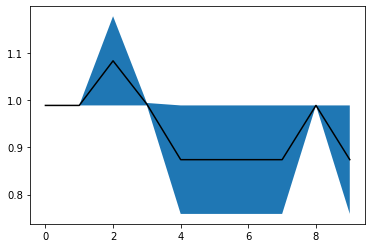

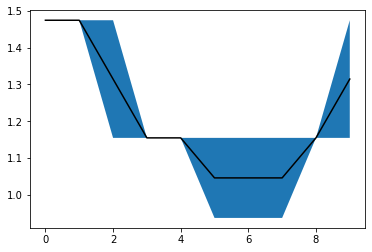

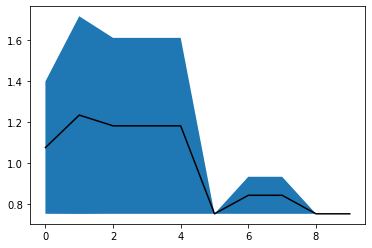

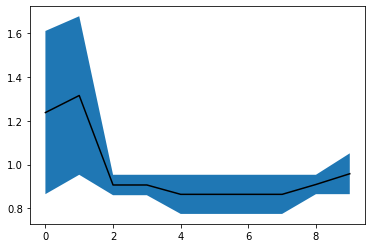

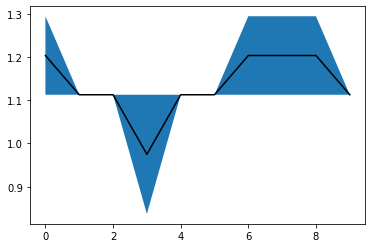

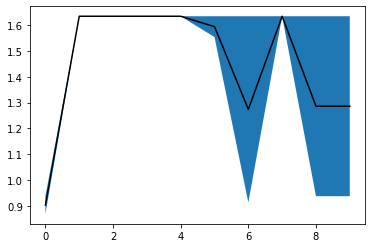

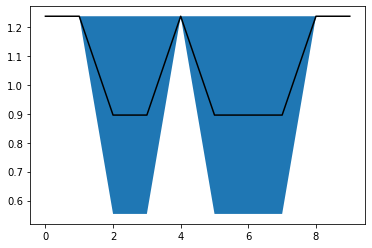

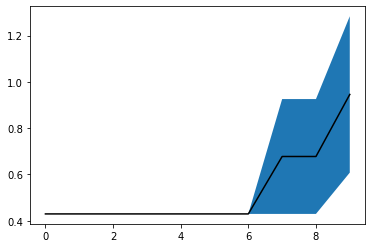

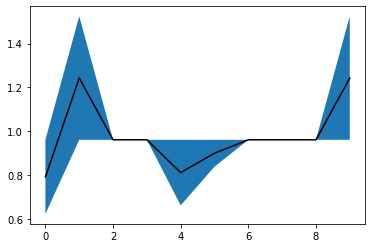

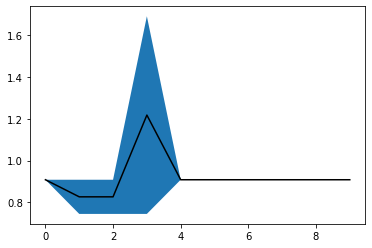

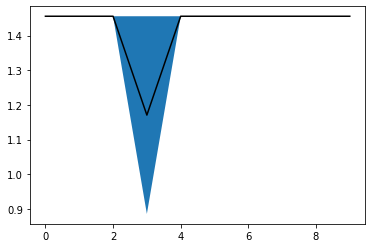

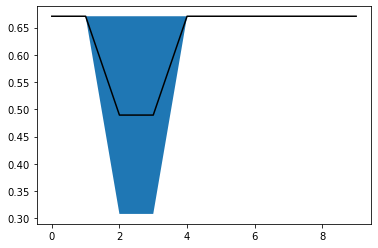

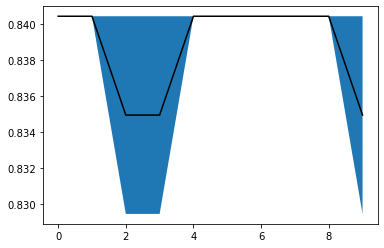

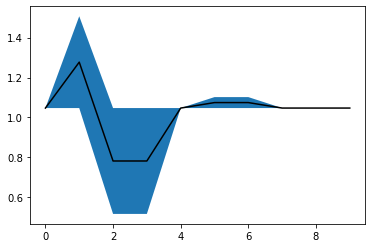

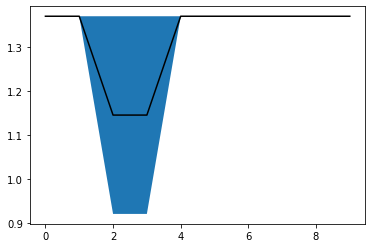

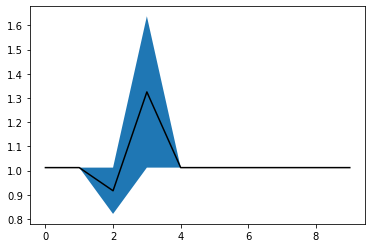

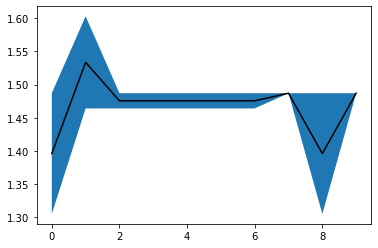

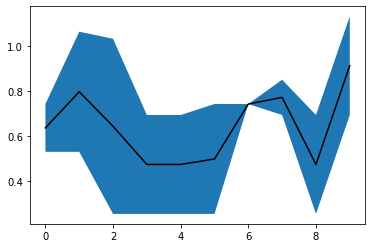

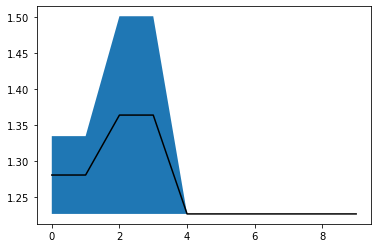

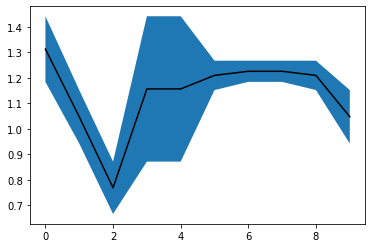

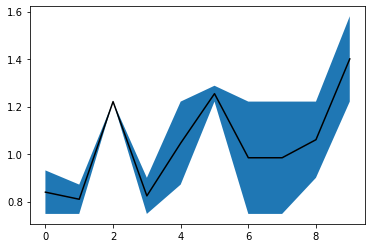

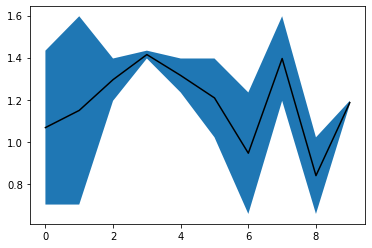

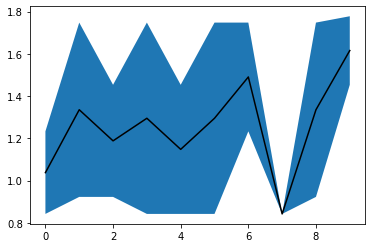

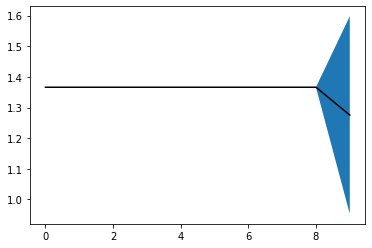

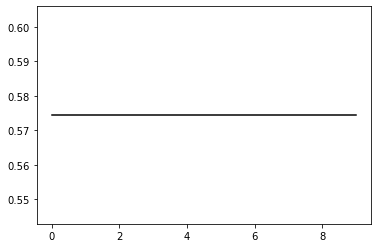

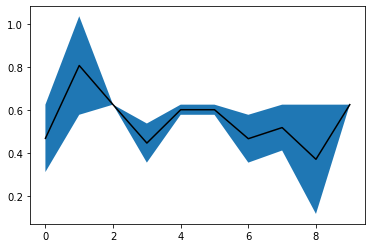

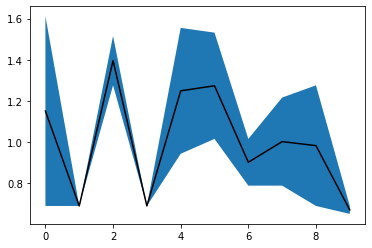

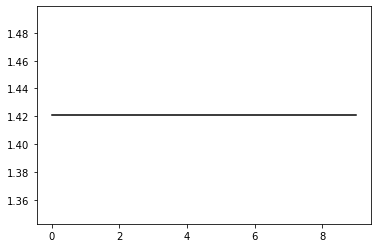

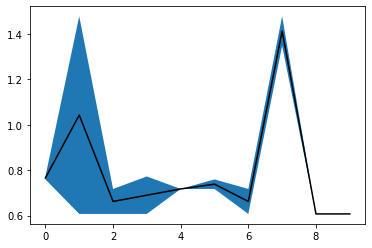

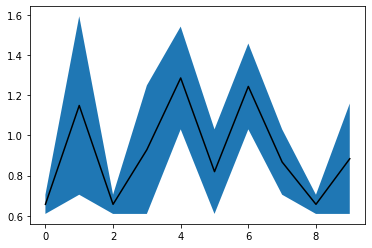

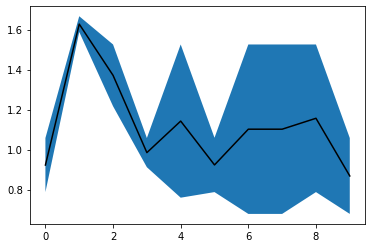

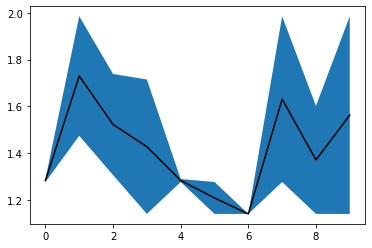

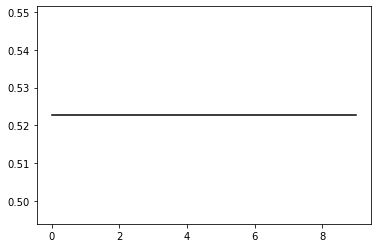

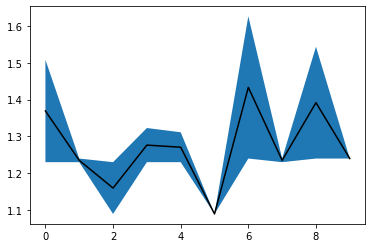

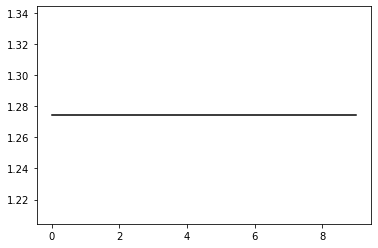

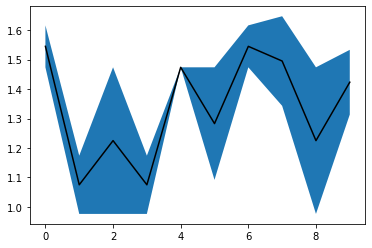

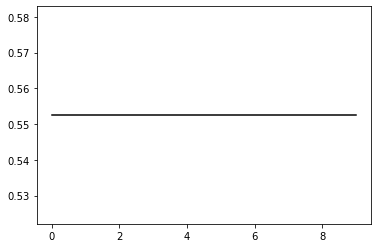

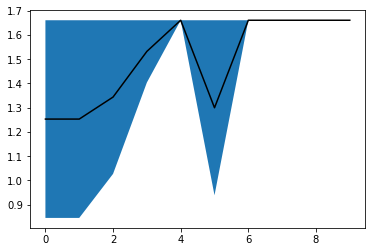

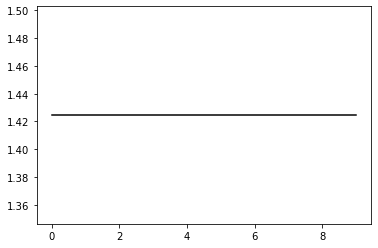

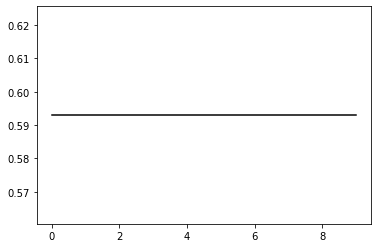

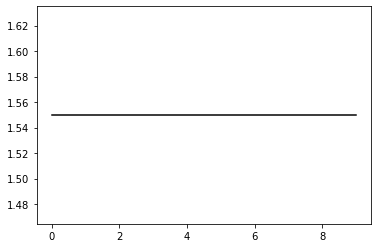

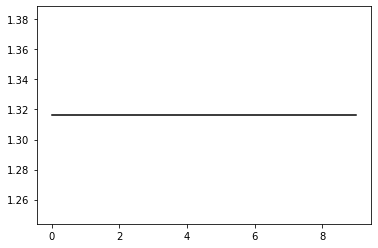

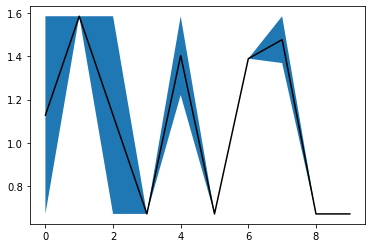

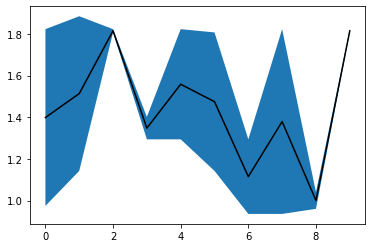

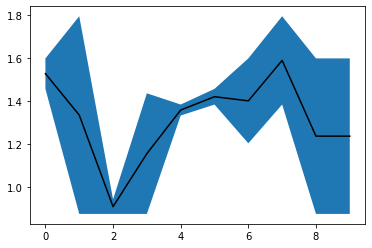

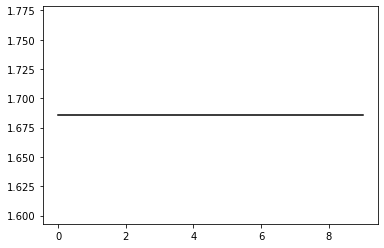

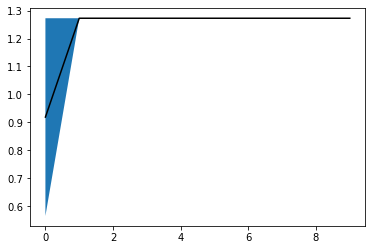

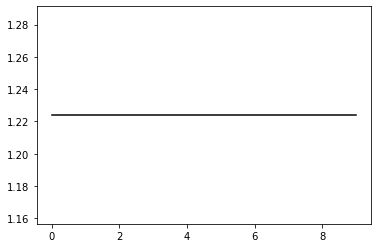

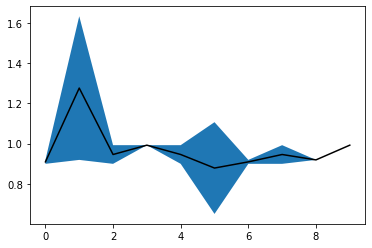

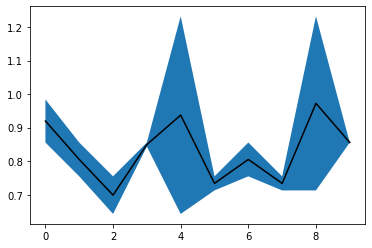

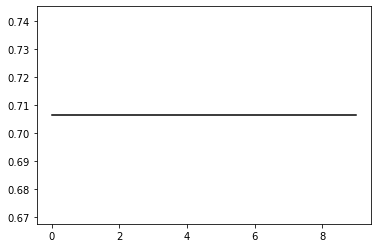

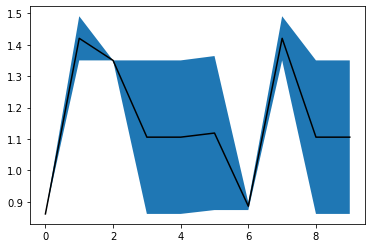

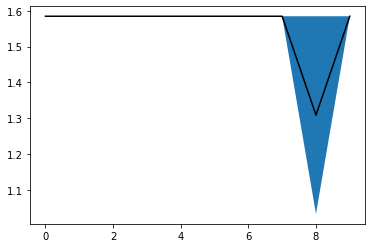

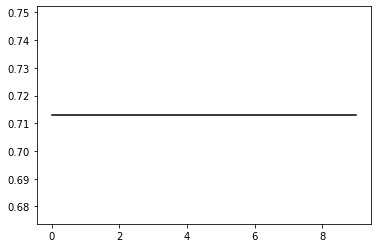

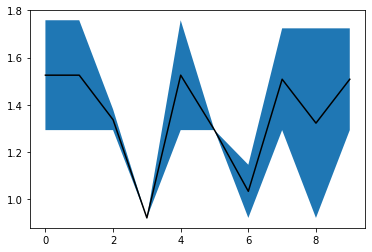

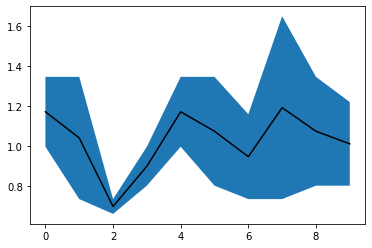

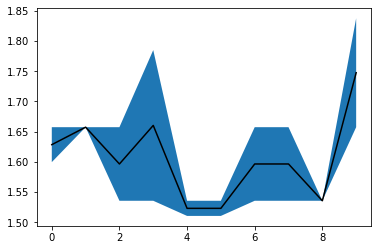

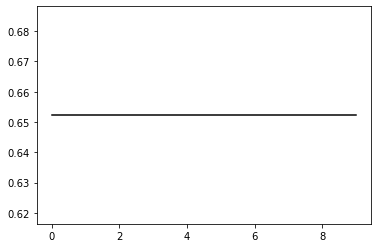

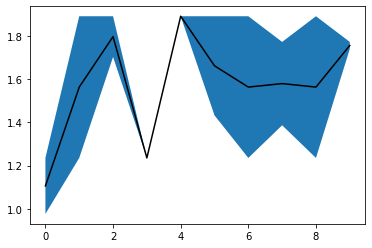

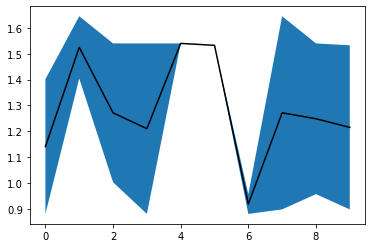

In [197]:
plot_lines(regret_lender)